In [1]:
# %%
from pathlib import Path

import torch
import numpy as np
import random
import pickle
from absl import logging
from absl.flags import FLAGS
from cellot import losses
from cellot.utils.loaders import load
from cellot.models.cellot import compute_loss_f, compute_loss_g, compute_w2_distance
from cellot.train.summary import Logger
from cellot.data.utils import cast_loader_to_iterator
from cellot.models.ae import compute_scgen_shift
from tqdm import trange

from cellot.models.ae import AutoEncoder

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
logger = logging.getLogger("data_logger")
logger.setLevel(logging.INFO)


In [2]:
DEBUG = True
TARGET = 'all' if not DEBUG else 'abexinostat'
LATENT_DIM = 50

from pathlib import Path
outdir_path = '/Mounts/rbg-storage1/users/johnyang/cellot/results/sciplex3/full_ae'
outdir = Path(outdir_path)

# %%
outdir.mkdir(exist_ok=True, parents=True)

cachedir = outdir / "cache"
cachedir.mkdir(exist_ok=True)

In [3]:

import torch
import GPUtil
import os

def get_free_gpu():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    # Set environment variables for which GPUs to use.
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    chosen_gpu = ''.join(
        [str(x) for x in GPUtil.getAvailable(order='memory')])
    os.environ["CUDA_VISIBLE_DEVICES"] = chosen_gpu
    print(f"Using GPUs: {chosen_gpu}")
    return chosen_gpu

status = cachedir / "status"
status.write_text("running")

device = f'cuda:{get_free_gpu()}'

cuda
Using GPUs: 1


In [4]:

# %%
import omegaconf

if DEBUG:
    n_iters = 250000
    batch_size = 256
else:
    n_iters = 250000
    batch_size = 256

yaml_str = f"""
model:
   name: scgen
   beta: 0.0
   dropout: 0.0
   hidden_units: [512, 512]
   latent_dim: 50

optim:
   lr: 0.001
   optimizer: Adam
   weight_decay: 1.0e-05

scheduler:
   gamma: 0.5
   step_size: 100000

training:
  cache_freq: 10000
  eval_freq: 2500
  logs_freq: 250
  n_iters: {n_iters}

data:
  type: cell
  source: control
  condition: drug
  path: /Mounts/rbg-storage1/users/johnyang/cellot/datasets/scrna-sciplex3/hvg.h5ad
  target: {TARGET}

datasplit:
    groupby: drug   
    name: train_test
    test_size: 0.2
    random_state: 0

dataloader:
    batch_size: {batch_size}
    shuffle: true
"""

config = omegaconf.OmegaConf.create(yaml_str)


In [5]:

# %% [markdown]
# ### Utils

# %%
def load_lr_scheduler(optim, config):
    if "scheduler" not in config:
        return None

    return torch.optim.lr_scheduler.StepLR(optim, **config.scheduler)

def check_loss(*args):
    for arg in args:
        if torch.isnan(arg):
            raise ValueError


def load_item_from_save(path, key, default):
    path = Path(path)
    if not path.exists():
        return default

    ckpt = torch.load(path)
    if key not in ckpt:
        logging.warn(f"'{key}' not found in ckpt: {str(path)}")
        return default

    return ckpt[key]

# %%
import cellot.models
from cellot.data.cell import load_cell_data


def load_data(config, **kwargs):
    data_type = config.get("data.type", "cell")
    if data_type in ["cell", "cell-merged", "tupro-cohort"]:
        loadfxn = load_cell_data

    elif data_type == "toy":
        loadfxn = load_toy_data

    else:
        raise ValueError

    return loadfxn(config, **kwargs)


def load_model(config, device, restore=None, **kwargs):
    # def load_autoencoder_model(config, restore=None, **kwargs):
    
    def load_optimizer(config, params):
        kwargs = dict(config.get("optim", {}))
        assert kwargs.pop("optimizer", "Adam") == "Adam"
        optim = torch.optim.Adam(params, **kwargs)
        return optim


    def load_networks(config, **kwargs):
        kwargs = kwargs.copy()
        kwargs.update(dict(config.get("model", {})))
        name = kwargs.pop("name")

        if name == "scgen":
            model = AutoEncoder

        # elif name == "cae":
        #     model = ConditionalAutoEncoder
        else:
            raise ValueError

        return model(**kwargs)
    
    model = load_networks(config, **kwargs)
    optim = load_optimizer(config, model.parameters())

    if restore is not None and Path(restore).exists():
        print('Loading model from checkpoint')
        ckpt = torch.load(restore, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optim.load_state_dict(ckpt["optim_state"])
        if config.model.name == "scgen" and "code_means" in ckpt:
            model.code_means = ckpt["code_means"]
            
    # logger.info(f'Model on device {next(model.parameters()).device}')

    return model, optim

def load(config, device, restore=None, include_model_kwargs=False, **kwargs):

    loader, model_kwargs = load_data(config, include_model_kwargs=True, **kwargs)

    model, opt = load_model(config, device, restore=restore, **model_kwargs)

    # if include_model_kwargs:
    #     return model, opt, loader, model_kwargs

    return model, opt, loader

# %% [markdown]
# ### Training


In [6]:
def state_dict(model, optim, **kwargs):
    state = {
        "model_state": model.state_dict(),
        "optim_state": optim.state_dict(),
    }

    if hasattr(model, "code_means"):
        state["code_means"] = model.code_means

    state.update(kwargs)

    return state

def evaluate(vinputs):
    with torch.no_grad():
        loss, comps, _ = model(vinputs)
        loss = loss.mean()
        comps = {k: v.mean().item() for k, v in comps._asdict().items()}
        check_loss(loss)
        logger.log("eval", loss=loss.item(), step=step, **comps)
    return loss

In [7]:
# _, _, loader = load(config, 'cuda', restore=cachedir / "last.pt")

In [8]:
"""R^3 diffusion methods."""
import numpy as np
from scipy.special import gamma
import torch


class R3Diffuser:
    """VP-SDE diffuser class for translations."""

    def __init__(self, r3_conf):
        """
        Args:
            min_b: starting value in variance schedule.
            max_b: ending value in variance schedule.
        """
        self._r3_conf = r3_conf
        self.min_b = r3_conf.min_b
        self.max_b = r3_conf.max_b
        self.schedule = r3_conf.schedule
        self._score_scaling = r3_conf.score_scaling
        self.latent_dim = r3_conf.latent_dim

    def _scale(self, x):
        return x * self._r3_conf.coordinate_scaling

    def _unscale(self, x):
        return x / self._r3_conf.coordinate_scaling

    def b_t(self, t):
        if np.any(t < 0) or np.any(t > 1):
            raise ValueError(f'Invalid t={t}')
        if self.schedule == 'linear': 
            return self.min_b + t*(self.max_b - self.min_b)
        elif self.schedule == 'cosine':
            return self.max_b + 0.5*(self.min_b - self.max_b)*(1 + np.cos(t*np.pi))
        elif self.schedule == 'exponential':
            sigma = t * np.log10(self.max_b) + (1 - t) * np.log10(self.min_b)
            return 10 ** sigma
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')
    
    def diffusion_coef(self, t):
        """Time-dependent diffusion coefficient."""
        return np.sqrt(self.b_t(t))

    def drift_coef(self, x, t):
        """Time-dependent drift coefficient."""
        return -1/2 * self.b_t(t) * x

    def sample_ref(self, n_samples: float=1):
        return np.random.normal(size=(n_samples, self.latent_dim))

    def marginal_b_t(self, t):
        if self.schedule == 'linear':
            return t*self.min_b + (1/2)*(t**2)*(self.max_b-self.min_b)
        elif self.schedule == 'exponential': 
            return (self.max_b**t * self.min_b**(1-t) - self.min_b) / (
                np.log(self.max_b) - np.log(self.min_b))
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')

    def calc_trans_0(self, score_t, x_t, t, use_torch=True):
        beta_t = self.marginal_b_t(t)
        beta_t = beta_t[..., None, None]
        exp_fn = torch.exp if use_torch else np.exp
        cond_var = 1 - exp_fn(-beta_t)
        return (score_t * cond_var + x_t) / exp_fn(-1/2*beta_t)

    def forward(self, x_t_1: np.ndarray, t: float, num_t: int):
        """Samples marginal p(x(t) | x(t-1)).

        Args:
            x_0: [..., n, 3] initial positions in Angstroms.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t in Angstroms.
            score_t: [..., n, 3] score at time t in scaled Angstroms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t_1 = self._scale(x_t_1)
        b_t = torch.tensor(self.marginal_b_t(t) / num_t).to(x_t_1.device)
        z_t_1 = torch.tensor(np.random.normal(size=x_t_1.shape)).to(x_t_1.device)
        x_t = torch.sqrt(1 - b_t) * x_t_1 + torch.sqrt(b_t) * z_t_1
        return x_t
    
    def distribution(self, x_t, score_t, t, mask, dt):
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        std = g_t * np.sqrt(dt)
        mu = x_t - (f_t - g_t**2 * score_t) * dt
        if mask is not None:
            mu *= mask[..., None]
        return mu, std

    def forward_marginal(self, x_0: np.ndarray, t: float):
        """Samples marginal p(x(t) | x(0)).

        Args:
            x_0: [..., n, 3] initial positions in Angstroms.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t in Angstroms.
            score_t: [..., n, 3] score at time t in scaled Angstroms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_0 = self._scale(x_0)
        x_t = np.random.normal(
            loc=np.exp(-1/2*self.marginal_b_t(t)) * x_0,
            scale=np.sqrt(1 - np.exp(-self.marginal_b_t(t)))
        )
        score_t = self.score(x_t, x_0, t)
        x_t = self._unscale(x_t)
        return x_t, score_t

    def score_scaling(self, t: float):
        if self._score_scaling == 'var':
            return 1 / self.conditional_var(t)
        elif self._score_scaling == 'std':
            return 1 / np.sqrt(self.conditional_var(t))
        elif self._score_scaling == 'expected_norm':
            return np.sqrt(2) / (gamma(1.5) * np.sqrt(self.conditional_var(t)))
        else:
            raise ValueError(f'Unrecognized scaling {self._score_scaling}')

    def reverse(
            self,
            *,
            x_t: np.ndarray,
            score_t: np.ndarray,
            t: float,
            dt: float,
            mask: np.ndarray=None,
            center: bool=True,
            ode: bool=False,
            noise_scale: float=1.0,
        ):
        """Simulates the reverse SDE for 1 step

        Args:
            x_t: [..., 3] current positions at time t in angstroms.
            score_t: [..., 3] rotation score at time t.
            t: continuous time in [0, 1].
            dt: continuous step size in [0, 1].
            mask: True indicates which residues to diffuse.

        Returns:
            [..., 3] positions at next step t-1.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        if ode:
            # Probability flow ODE
            perturb = (f_t - (1/2)*(g_t**2) * score_t) * dt
        else:
            # Usual stochastic dynamics
            z = noise_scale * np.random.normal(size=score_t.shape)
            perturb = (f_t - g_t**2 * score_t) * dt + g_t * np.sqrt(dt) * z

        if mask is not None:
            perturb *= mask[..., None]
        else:
            mask = np.ones(x_t.shape[:-1])
        x_t_1 = x_t - perturb
        if center:
            com = np.sum(x_t_1, axis=-2) / np.sum(mask, axis=-1)[..., None]
            x_t_1 -= com[..., None, :]
        x_t_1 = self._unscale(x_t_1)
        return x_t_1

    def conditional_var(self, t, use_torch=False):
        """Conditional variance of p(xt|x0).

        Var[x_t|x_0] = conditional_var(t)*I

        """
        if use_torch:
            return 1 - torch.exp(-self.marginal_b_t(t))
        return 1 - np.exp(-self.marginal_b_t(t))

    def score(self, x_t, x_0, t, use_torch=False, scale=False):
        if use_torch:
            exp_fn = torch.exp
        else:
            exp_fn = np.exp
        if scale:
            x_t = self._scale(x_t)
            x_0 = self._scale(x_0)
        return -(x_t - exp_fn(-1/2*self.marginal_b_t(t)) * x_0) / self.conditional_var(t, use_torch=use_torch)

In [9]:
from omegaconf import OmegaConf

r3_conf = OmegaConf.create({
    'min_b': 0.01,
    'max_b': 1.0,
    'schedule': 'linear',
    'score_scaling': 'var',
    'coordinate_scaling': 1.0,
    'latent_dim': LATENT_DIM,
})

In [10]:
diffuser = R3Diffuser(r3_conf)

In [11]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Linear
import torch.nn as nn

In [12]:
model_dim = 64
num_layers = 2
nhead = 1
dim_feedforward = 128
dropout = 0.1 if not DEBUG else 0.0

import torch.nn as nn
import torch.nn.functional as F
import math
import functools as fn

class FeedForward(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=64, output_dim=50):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def get_timestep_embedding(timesteps, embedding_dim, max_positions=10000):
    # Code from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py
    assert len(timesteps.shape) == 1
    timesteps = timesteps * max_positions
    half_dim = embedding_dim // 2
    emb = math.log(max_positions) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1), mode='constant')
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

class ScoreNetwork(nn.Module):
    def __init__(self):
        super(ScoreNetwork, self).__init__()
        
        self.latent_dim = LATENT_DIM
        self.model_dim = model_dim
        self.dropout = dropout
        print(f'Dropout is {self.dropout}')
        self.embed_code_and_t = nn.Linear(LATENT_DIM + model_dim, model_dim)
        # self.trmr_layer = TransformerEncoderLayer(d_model=model_dim, nhead=8, dim_feedforward=2048, dropout=dropout)
        self.pred_score = FeedForward(input_dim=model_dim, hidden_dim=64, output_dim=LATENT_DIM)
        self.model = nn.ModuleList([self.embed_code_and_t, self.pred_score]) #*[self.trmr_layer for _ in range(num_layers)], self.pred_score])
        
        self.timestep_embedder = fn.partial(
            get_timestep_embedding,
            embedding_dim=self.model_dim,
            # max_positions=100
        )

    def forward(self, x, t):
        device = x.device
        B, C = x.shape
        t_embed = torch.tile(self.timestep_embedder(torch.tensor([t]).to(device)), dims=[B, 1])
        
        x = torch.cat([x, t_embed], dim=-1).to(device)
        
        for module in self.model[:-1]:  # iterate over all modules except the last one
            x = module(x)
        x = self.model[-1](x.squeeze(0))  # pass through the last module (FeedForward)
        return x

In [13]:
score_network = ScoreNetwork().to(device)

Dropout is 0.0


In [14]:
sum(p.numel() for p in score_network.parameters())

14770

In [15]:
optimizer = torch.optim.Adam(score_network.parameters(), lr=1e-4)

In [29]:
STEP = 0
ticker = trange(STEP, n_iters, initial=STEP, total=n_iters)

  0%|                                                                                                                                                                         | 0/250000 [00:00<?, ?it/s]

In [17]:
# iterator = cast_loader_to_iterator(loader, cycle_all=True)

In [18]:
# inputs = next(iterator.train).to(device)
# inputs.shape

In [19]:
# ae.to(device)

In [20]:
# with torch.no_grad():
#     ex_code = ae.encode(ex_batch).to(device)[None, 0, :1]

In [21]:
# ex_code

In [22]:
ex_code = torch.ones((1, 50)).to(device)

In [23]:
ex_code.shape

torch.Size([1, 50])

In [24]:
min_t = 0.0
rng = np.random.default_rng(42)

In [25]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/6.29.23_just_mlp_KD')


In [26]:
import torch
torch.__version__

'2.0.1'

In [27]:
def eval(dt=0.001):
    score_network.eval()
    # log_freq = (1 / dt) / 100
    ex_code_np = ex_code.detach().cpu().numpy()
    with torch.no_grad():
        x_t, _ = diffuser.forward_marginal(ex_code_np, t=1.0)
        
        for i, t in enumerate(np.arange(1.0, 0, -dt)):
            # if i % log_freq == 0:
                # print(x_t)
            x_t = torch.tensor(x_t).float().to(device)
            pred_score = score_network(x_t, t)
            
            # pred_scores.append(pred_score)
            # gt_scores.append(gt_score)
            
            # _, gt_score = diffuser.forward_marginal(ex_code_np.detach().cpu().numpy(), t=t)

            # print(pred_score, gt_score)
            
            x_t = diffuser.reverse(x_t=x_t.detach().cpu().numpy(), score_t=pred_score.detach().cpu().numpy(), t=t, dt=dt, center=False)
        
        x_0 = x_t
        writer.add_embedding(x_0, global_step=step, tag='reverse_sampled_x_0')
        writer.add_embedding(ex_code_np, global_step=step, tag='gt_x_0')
        euclidean_distance = np.linalg.norm(x_0 - ex_code_np)
        writer.add_scalar('sampled_gt_dist', euclidean_distance, global_step=step)
        
        return x_0

In [ ]:
eval_freq=1000
for step in ticker:

    score_network.train()
    
    # if DEBUG:
    #     inputs = ex_batch
    # else:
    #     raise NotImplementedError
    #     inputs = next(iterator.train)
    #     # inputs = inputs.to(device)
        
        
    optimizer.zero_grad()
    # '''
    # Get encoded representation
    # '''
    
    # code = ae.encode(inputs)
    
    t = rng.uniform(min_t, 1.0)
    x_t, gt_score_t = diffuser.forward_marginal(ex_code.detach().cpu().numpy(), t=t)
    
    score_scaling = torch.tensor(diffuser.score_scaling(t)).to(device)
    gt_score_t = torch.tensor(gt_score_t).to(device)
    
    pred_score_t = score_network(torch.tensor(x_t).float().to(device), t)

    score_mse = (gt_score_t - pred_score_t)**2
    score_loss = torch.sum(
        score_mse / score_scaling[None, None]**2,
        dim=(-1, -2)
    ) #/ (loss_mask.sum(dim=-1) + 1e-10)    
    
    # comps = {k: v.mean().item() for k, v in comps._asdict().items()}
    score_loss.backward()
    optimizer.step()
    # check_loss(score_)

    if step % config.training.logs_freq == 0:
        # log to logger object
        # logger.log("train", loss=loss.item(), step=step, **comps)
        writer.add_scalar('Training loss', score_loss.item(), global_step=step)
        print(f'At step {step}, TRAINING loss is {score_loss.item()}')
        
    if step % eval_freq == 0:
        sampled_x_0 = eval(dt=0.01)
        print(f'At step {step}, sampled x_0 is {sampled_x_0[:, :2]}')


At step 0, TRAINING loss is 9.324869159776895


  0%|                                                                                                                                                             | 6/250000 [00:26<229:07:28,  3.30s/it]

At step 0, sampled x_0 is [[0.50457698 0.48538044]]


  0%|▏                                                                                                                                                            | 257/250000 [00:32<1:38:43, 42.16it/s]

At step 250, TRAINING loss is 6.1476639802343716


  0%|▎                                                                                                                                                            | 507/250000 [00:38<1:36:52, 42.92it/s]

At step 500, TRAINING loss is 0.02079265143426566


  0%|▍                                                                                                                                                            | 757/250000 [00:44<1:31:15, 45.52it/s]

At step 750, TRAINING loss is 2.241371571861477


  0%|▋                                                                                                                                                            | 997/250000 [00:49<1:32:38, 44.80it/s]

At step 1000, TRAINING loss is 15.04563556874262


  0%|▋                                                                                                                                                           | 1007/250000 [00:50<3:55:09, 17.65it/s]

At step 1000, sampled x_0 is [[ 0.97205262 -0.20700971]]


  1%|▊                                                                                                                                                           | 1257/250000 [00:56<1:29:16, 46.44it/s]

At step 1250, TRAINING loss is 1.0866335253332533


  1%|▉                                                                                                                                                           | 1507/250000 [01:01<1:32:06, 44.97it/s]

At step 1500, TRAINING loss is 0.17390081892137485


  1%|█                                                                                                                                                           | 1757/250000 [01:07<1:28:55, 46.53it/s]

At step 1750, TRAINING loss is 6.656662567451059


  1%|█▏                                                                                                                                                          | 1996/250000 [01:12<1:29:59, 45.93it/s]

At step 2000, TRAINING loss is 17.34319175577793


  1%|█▎                                                                                                                                                          | 2006/250000 [01:13<3:57:24, 17.41it/s]

At step 2000, sampled x_0 is [[2.30497772 1.74918294]]


  1%|█▍                                                                                                                                                          | 2256/250000 [01:19<1:34:11, 43.84it/s]

At step 2250, TRAINING loss is 8.77884646479557


  1%|█▌                                                                                                                                                          | 2506/250000 [01:24<1:28:58, 46.36it/s]

At step 2500, TRAINING loss is 10.18981573219172


  1%|█▋                                                                                                                                                          | 2756/250000 [01:30<1:38:49, 41.70it/s]

At step 2750, TRAINING loss is 13.105586694677386


  1%|█▊                                                                                                                                                          | 3000/250000 [01:35<1:28:46, 46.37it/s]

At step 3000, TRAINING loss is 13.688282820680453
At step 3000, sampled x_0 is [[2.91017683 2.13161999]]


  1%|██                                                                                                                                                          | 3260/250000 [01:42<1:29:32, 45.93it/s]

At step 3250, TRAINING loss is 3.81940954000475


  1%|██▏                                                                                                                                                         | 3510/250000 [01:48<1:30:24, 45.44it/s]

At step 3500, TRAINING loss is 7.921482244864591


  2%|██▎                                                                                                                                                         | 3759/250000 [01:53<1:32:19, 44.45it/s]

At step 3750, TRAINING loss is 5.787498942470435


  2%|██▍                                                                                                                                                         | 3999/250000 [01:59<1:29:32, 45.79it/s]

At step 4000, TRAINING loss is 5.6449901625452625


  2%|██▌                                                                                                                                                         | 4009/250000 [02:00<3:47:13, 18.04it/s]

At step 4000, sampled x_0 is [[2.03971689 0.29811255]]


  2%|██▋                                                                                                                                                         | 4259/250000 [02:05<1:28:58, 46.04it/s]

At step 4250, TRAINING loss is 1.0772556036346965


  2%|██▊                                                                                                                                                         | 4509/250000 [02:11<1:38:11, 41.67it/s]

At step 4500, TRAINING loss is 3.8746360061818512


  2%|██▉                                                                                                                                                         | 4759/250000 [02:16<1:29:51, 45.48it/s]

At step 4750, TRAINING loss is 1.05925154522212


  2%|███                                                                                                                                                         | 4999/250000 [02:22<1:29:54, 45.42it/s]

At step 5000, TRAINING loss is 0.5727294711425971


  2%|███▏                                                                                                                                                        | 5009/250000 [02:23<4:08:32, 16.43it/s]

At step 5000, sampled x_0 is [[1.78487565 0.87041888]]


  2%|███▎                                                                                                                                                        | 5256/250000 [02:28<1:41:38, 40.13it/s]

At step 5250, TRAINING loss is 0.5777912368214133


  2%|███▍                                                                                                                                                        | 5506/250000 [02:34<1:29:04, 45.75it/s]

At step 5500, TRAINING loss is 0.5764414805145215


  2%|███▌                                                                                                                                                        | 5758/250000 [02:40<1:38:00, 41.54it/s]

At step 5750, TRAINING loss is 9.50781150741704


  2%|███▋                                                                                                                                                        | 5998/250000 [02:45<1:30:18, 45.03it/s]

At step 6000, TRAINING loss is 0.7080804650273878


  2%|███▋                                                                                                                                                        | 6008/250000 [02:46<4:05:12, 16.58it/s]

At step 6000, sampled x_0 is [[1.42509818 1.32593067]]


  3%|███▉                                                                                                                                                        | 6256/250000 [02:52<1:34:48, 42.85it/s]

At step 6250, TRAINING loss is 10.579005989053723


  3%|████                                                                                                                                                        | 6506/250000 [02:58<1:29:09, 45.52it/s]

At step 6500, TRAINING loss is 7.506427249157408


  3%|████▏                                                                                                                                                       | 6756/250000 [03:03<1:39:42, 40.66it/s]

At step 6750, TRAINING loss is 5.789553218572635


  3%|████▎                                                                                                                                                       | 6996/250000 [03:09<1:31:11, 44.41it/s]

At step 7000, TRAINING loss is 2.73979700976106


  3%|████▎                                                                                                                                                       | 7006/250000 [03:10<4:01:30, 16.77it/s]

At step 7000, sampled x_0 is [[ 2.79170252 -0.86201967]]


  3%|████▌                                                                                                                                                       | 7259/250000 [03:16<1:32:11, 43.88it/s]

At step 7250, TRAINING loss is 18.625347101106097


  3%|████▋                                                                                                                                                       | 7509/250000 [03:22<1:31:07, 44.35it/s]

At step 7500, TRAINING loss is 1.1608804094261265


  3%|████▊                                                                                                                                                       | 7759/250000 [03:27<1:31:11, 44.27it/s]

At step 7750, TRAINING loss is 5.071276605074123


  3%|████▉                                                                                                                                                       | 7999/250000 [03:33<1:28:43, 45.46it/s]

At step 8000, TRAINING loss is 1.5101869677870186


  3%|████▉                                                                                                                                                       | 8009/250000 [03:34<4:04:48, 16.47it/s]

At step 8000, sampled x_0 is [[0.50486289 0.23619258]]


  3%|█████▏                                                                                                                                                      | 8259/250000 [03:39<1:29:33, 44.99it/s]

At step 8250, TRAINING loss is 3.8234463255332614


  3%|█████▎                                                                                                                                                      | 8509/250000 [03:45<1:28:09, 45.66it/s]

At step 8500, TRAINING loss is 15.170269159378048


  4%|█████▍                                                                                                                                                      | 8759/250000 [03:51<1:29:57, 44.70it/s]

At step 8750, TRAINING loss is 0.5051821831727161


  4%|█████▌                                                                                                                                                      | 8999/250000 [03:56<1:31:17, 44.00it/s]

At step 9000, TRAINING loss is 5.553557328124489


  4%|█████▌                                                                                                                                                      | 9009/250000 [03:58<5:02:47, 13.26it/s]

At step 9000, sampled x_0 is [[0.52944924 1.92158886]]


  4%|█████▊                                                                                                                                                      | 9258/250000 [04:03<1:29:26, 44.86it/s]

At step 9250, TRAINING loss is 9.046347258807636


  4%|█████▉                                                                                                                                                      | 9507/250000 [04:09<1:28:56, 45.07it/s]

At step 9500, TRAINING loss is 0.09207347133679977


  4%|██████                                                                                                                                                      | 9755/250000 [04:15<1:34:26, 42.40it/s]

At step 9750, TRAINING loss is 9.979439631349612


  4%|██████▏                                                                                                                                                     | 9999/250000 [04:21<1:32:09, 43.40it/s]

At step 10000, TRAINING loss is 0.0014040742676070341


  4%|██████▏                                                                                                                                                    | 10009/250000 [04:22<4:47:12, 13.93it/s]

At step 10000, sampled x_0 is [[2.15030501 2.02440651]]


  4%|██████▎                                                                                                                                                    | 10257/250000 [04:28<1:35:27, 41.86it/s]

At step 10250, TRAINING loss is 12.30003128161973


  4%|██████▌                                                                                                                                                    | 10506/250000 [04:34<1:39:15, 40.21it/s]

At step 10500, TRAINING loss is 9.328672109795662


  4%|██████▋                                                                                                                                                    | 10759/250000 [04:40<1:34:13, 42.32it/s]

At step 10750, TRAINING loss is 2.3355401824614215


  4%|██████▊                                                                                                                                                    | 10998/250000 [04:45<1:39:48, 39.91it/s]

At step 11000, TRAINING loss is 2.9447664654908747


  4%|██████▊                                                                                                                                                    | 11008/250000 [04:46<4:08:17, 16.04it/s]

At step 11000, sampled x_0 is [[0.38097428 0.33329486]]


  5%|██████▉                                                                                                                                                    | 11258/250000 [04:52<1:26:14, 46.13it/s]

At step 11250, TRAINING loss is 0.1079736594416957


  5%|███████▏                                                                                                                                                   | 11508/250000 [04:58<1:30:56, 43.71it/s]

At step 11500, TRAINING loss is 2.3658155772007836


  5%|███████▎                                                                                                                                                   | 11758/250000 [05:03<1:26:57, 45.67it/s]

At step 11750, TRAINING loss is 19.011533886135247


  5%|███████▍                                                                                                                                                   | 11998/250000 [05:09<1:33:50, 42.27it/s]

At step 12000, TRAINING loss is 0.6262749728004585


  5%|███████▍                                                                                                                                                   | 12008/250000 [05:10<4:10:22, 15.84it/s]

At step 12000, sampled x_0 is [[2.20124359 3.36103777]]


  5%|███████▌                                                                                                                                                   | 12258/250000 [05:16<1:26:23, 45.86it/s]

At step 12250, TRAINING loss is 3.1159014708417647


  5%|███████▊                                                                                                                                                   | 12507/250000 [05:21<1:42:12, 38.72it/s]

At step 12500, TRAINING loss is 12.527635702841225


  5%|███████▉                                                                                                                                                   | 12758/250000 [05:27<1:28:51, 44.50it/s]

At step 12750, TRAINING loss is 11.42494575855887


  5%|████████                                                                                                                                                   | 12996/250000 [05:33<1:28:46, 44.50it/s]

At step 13000, TRAINING loss is 5.1022287164641815


  5%|████████                                                                                                                                                   | 13005/250000 [05:34<4:04:03, 16.18it/s]

At step 13000, sampled x_0 is [[1.71598385 1.20172896]]


  5%|████████▏                                                                                                                                                  | 13258/250000 [05:40<1:44:27, 37.77it/s]

At step 13250, TRAINING loss is 12.413939107150709


  5%|████████▍                                                                                                                                                  | 13510/250000 [05:45<1:26:42, 45.46it/s]

At step 13500, TRAINING loss is 7.412854724592135


  6%|████████▌                                                                                                                                                  | 13756/250000 [05:51<1:30:09, 43.67it/s]

At step 13750, TRAINING loss is 3.476950701125429


  6%|████████▋                                                                                                                                                  | 13999/250000 [05:57<1:26:08, 45.66it/s]

At step 14000, TRAINING loss is 7.019206291732046


  6%|████████▋                                                                                                                                                  | 14008/250000 [05:58<3:58:10, 16.51it/s]

At step 14000, sampled x_0 is [[0.21995478 1.1403005 ]]


  6%|████████▊                                                                                                                                                  | 14255/250000 [06:04<1:35:41, 41.06it/s]

At step 14250, TRAINING loss is 0.9676532808577497


  6%|████████▉                                                                                                                                                  | 14508/250000 [06:10<1:27:29, 44.86it/s]

At step 14500, TRAINING loss is 10.540893354673832


  6%|█████████▏                                                                                                                                                 | 14758/250000 [06:15<1:31:05, 43.04it/s]

At step 14750, TRAINING loss is 8.328691019146932


  6%|█████████▎                                                                                                                                                 | 14996/250000 [06:21<1:33:43, 41.79it/s]

At step 15000, TRAINING loss is 2.166146913410283


  6%|█████████▎                                                                                                                                                 | 15005/250000 [06:22<4:41:32, 13.91it/s]

At step 15000, sampled x_0 is [[ 0.73871988 -1.16585205]]


  6%|█████████▍                                                                                                                                                 | 15260/250000 [06:28<1:27:48, 44.55it/s]

At step 15250, TRAINING loss is 1.6689268653639768


  6%|█████████▌                                                                                                                                                 | 15510/250000 [06:33<1:27:38, 44.59it/s]

At step 15500, TRAINING loss is 5.506904687891991


  6%|█████████▊                                                                                                                                                 | 15760/250000 [06:39<1:26:46, 44.99it/s]

At step 15750, TRAINING loss is 2.9631503220155704


  6%|█████████▉                                                                                                                                                 | 16000/250000 [06:44<1:23:35, 46.65it/s]

At step 16000, TRAINING loss is 4.7128404290041495


  6%|█████████▉                                                                                                                                                 | 16010/250000 [06:45<3:49:34, 16.99it/s]

At step 16000, sampled x_0 is [[-0.29672258  2.6645309 ]]


  7%|██████████                                                                                                                                                 | 16260/250000 [06:51<1:28:13, 44.15it/s]

At step 16250, TRAINING loss is 2.1992920687814843


  7%|██████████▏                                                                                                                                                | 16505/250000 [06:56<1:30:06, 43.19it/s]

At step 16500, TRAINING loss is 5.392240354218522


  7%|██████████▍                                                                                                                                                | 16755/250000 [07:02<1:27:21, 44.50it/s]

At step 16750, TRAINING loss is 4.532915419607861


  7%|██████████▌                                                                                                                                                | 16999/250000 [07:08<1:34:28, 41.10it/s]

At step 17000, TRAINING loss is 5.347214049611058


  7%|██████████▌                                                                                                                                                | 17009/250000 [07:09<4:05:43, 15.80it/s]

At step 17000, sampled x_0 is [[1.50453419 0.27193624]]


  7%|██████████▋                                                                                                                                                | 17258/250000 [07:15<1:29:31, 43.33it/s]

At step 17250, TRAINING loss is 4.767452203842043


  7%|██████████▊                                                                                                                                                | 17508/250000 [07:20<1:27:13, 44.43it/s]

At step 17500, TRAINING loss is 7.142459632898744


  7%|███████████                                                                                                                                                | 17758/250000 [07:26<1:25:50, 45.09it/s]

At step 17750, TRAINING loss is 6.67991035811608


  7%|███████████▏                                                                                                                                               | 17998/250000 [07:31<1:25:53, 45.02it/s]

At step 18000, TRAINING loss is 7.9472649226736936


  7%|███████████▏                                                                                                                                               | 18007/250000 [07:33<4:39:19, 13.84it/s]

At step 18000, sampled x_0 is [[1.62558231 0.40491458]]


  7%|███████████▎                                                                                                                                               | 18257/250000 [07:38<1:30:55, 42.48it/s]

At step 18250, TRAINING loss is 5.2414167207647075


  7%|███████████▍                                                                                                                                               | 18507/250000 [07:44<1:24:21, 45.74it/s]

At step 18500, TRAINING loss is 5.801379016917711


  8%|███████████▋                                                                                                                                               | 18757/250000 [07:49<1:27:13, 44.19it/s]

At step 18750, TRAINING loss is 0.0020549465882734597


  8%|███████████▊                                                                                                                                               | 18997/250000 [07:55<1:23:11, 46.28it/s]

At step 19000, TRAINING loss is 0.0036831962771321884


  8%|███████████▊                                                                                                                                               | 19007/250000 [07:56<3:40:51, 17.43it/s]

At step 19000, sampled x_0 is [[ 0.4719806  -1.09905814]]


  8%|███████████▉                                                                                                                                               | 19257/250000 [08:01<1:29:24, 43.01it/s]

At step 19250, TRAINING loss is 0.4783058208558614


  8%|████████████                                                                                                                                               | 19507/250000 [08:07<1:25:58, 44.68it/s]

At step 19500, TRAINING loss is 8.13173261317133


  8%|████████████▏                                                                                                                                              | 19757/250000 [08:13<1:41:34, 37.78it/s]

At step 19750, TRAINING loss is 7.905727692381133


  8%|████████████▍                                                                                                                                              | 19999/250000 [08:18<1:28:49, 43.15it/s]

At step 20000, TRAINING loss is 7.254880880592733


  8%|████████████▍                                                                                                                                              | 20009/250000 [08:20<3:53:40, 16.40it/s]

At step 20000, sampled x_0 is [[1.10363429 1.68006854]]


  8%|████████████▌                                                                                                                                              | 20255/250000 [08:26<1:35:27, 40.11it/s]

At step 20250, TRAINING loss is 0.026618871071028435


  8%|████████████▋                                                                                                                                              | 20509/250000 [08:31<1:25:33, 44.70it/s]

At step 20500, TRAINING loss is 1.3055252443997378


  8%|████████████▊                                                                                                                                              | 20759/250000 [08:37<1:30:18, 42.31it/s]

At step 20750, TRAINING loss is 0.4639230871783372


  8%|█████████████                                                                                                                                              | 20999/250000 [08:43<1:27:41, 43.52it/s]

At step 21000, TRAINING loss is 11.088352327867337


  8%|█████████████                                                                                                                                              | 21009/250000 [08:44<3:52:29, 16.42it/s]

At step 21000, sampled x_0 is [[1.84197024 1.03539124]]


  9%|█████████████▏                                                                                                                                             | 21259/250000 [08:49<1:26:45, 43.94it/s]

At step 21250, TRAINING loss is 1.8405232935396816


  9%|█████████████▎                                                                                                                                             | 21509/250000 [08:55<1:25:37, 44.48it/s]

At step 21500, TRAINING loss is 1.2044713018393867


  9%|█████████████▍                                                                                                                                             | 21759/250000 [09:01<1:26:13, 44.12it/s]

At step 21750, TRAINING loss is 4.385552333783544


  9%|█████████████▋                                                                                                                                             | 21999/250000 [09:06<1:28:44, 42.82it/s]

At step 22000, TRAINING loss is 13.108566569522953


  9%|█████████████▋                                                                                                                                             | 22009/250000 [09:07<3:42:44, 17.06it/s]

At step 22000, sampled x_0 is [[0.44475602 2.37586621]]


  9%|█████████████▊                                                                                                                                             | 22259/250000 [09:13<1:31:12, 41.61it/s]

At step 22250, TRAINING loss is 6.4293958723817015


  9%|█████████████▉                                                                                                                                             | 22509/250000 [09:18<1:24:39, 44.78it/s]

At step 22500, TRAINING loss is 5.756835355609687


  9%|██████████████                                                                                                                                             | 22759/250000 [09:24<1:24:54, 44.60it/s]

At step 22750, TRAINING loss is 8.213761608664932


  9%|██████████████▎                                                                                                                                            | 22999/250000 [09:29<1:23:07, 45.51it/s]

At step 23000, TRAINING loss is 3.141403271790659


  9%|██████████████▎                                                                                                                                            | 23009/250000 [09:30<3:58:42, 15.85it/s]

At step 23000, sampled x_0 is [[1.56386876 0.29169054]]


  9%|██████████████▍                                                                                                                                            | 23259/250000 [09:36<1:23:53, 45.04it/s]

At step 23250, TRAINING loss is 6.156617936142579


  9%|██████████████▌                                                                                                                                            | 23508/250000 [09:41<1:21:45, 46.17it/s]

At step 23500, TRAINING loss is 6.28008009306158


 10%|██████████████▋                                                                                                                                            | 23758/250000 [09:47<1:22:33, 45.68it/s]

At step 23750, TRAINING loss is 7.572971861856204


 10%|██████████████▉                                                                                                                                            | 23998/250000 [09:52<1:24:54, 44.36it/s]

At step 24000, TRAINING loss is 7.220709119626492


 10%|██████████████▉                                                                                                                                            | 24008/250000 [09:53<3:48:24, 16.49it/s]

At step 24000, sampled x_0 is [[1.34134447 0.71320326]]


 10%|███████████████                                                                                                                                            | 24258/250000 [09:59<1:22:45, 45.46it/s]

At step 24250, TRAINING loss is 0.2778397196022383


 10%|███████████████▏                                                                                                                                           | 24507/250000 [10:05<1:24:57, 44.24it/s]

At step 24500, TRAINING loss is 3.818189480273568


 10%|███████████████▎                                                                                                                                           | 24757/250000 [10:10<1:22:13, 45.66it/s]

At step 24750, TRAINING loss is 5.158082002617498


 10%|███████████████▌                                                                                                                                           | 25000/250000 [10:16<1:23:50, 44.73it/s]

At step 25000, TRAINING loss is 4.044835969150512


 10%|███████████████▌                                                                                                                                           | 25005/250000 [10:17<4:59:20, 12.53it/s]

At step 25000, sampled x_0 is [[ 0.9806472 -0.7380722]]


 10%|███████████████▋                                                                                                                                           | 25260/250000 [10:23<1:30:11, 41.53it/s]

At step 25250, TRAINING loss is 0.783511447807089


 10%|███████████████▊                                                                                                                                           | 25510/250000 [10:29<1:24:25, 44.32it/s]

At step 25500, TRAINING loss is 0.617945568450811


 10%|███████████████▉                                                                                                                                           | 25755/250000 [10:35<1:33:18, 40.05it/s]

At step 25750, TRAINING loss is 3.422512115060984


 10%|████████████████                                                                                                                                           | 25998/250000 [10:40<1:23:36, 44.65it/s]

At step 26000, TRAINING loss is 2.987848870677944


 10%|████████████████                                                                                                                                           | 26007/250000 [10:41<3:54:50, 15.90it/s]

At step 26000, sampled x_0 is [[1.63594625 1.02660243]]


 11%|████████████████▎                                                                                                                                          | 26259/250000 [10:47<1:26:22, 43.17it/s]

At step 26250, TRAINING loss is 7.791253691014696


 11%|████████████████▍                                                                                                                                          | 26509/250000 [10:53<1:21:36, 45.64it/s]

At step 26500, TRAINING loss is 1.6159845824506562


 11%|████████████████▌                                                                                                                                          | 26759/250000 [10:58<1:27:31, 42.51it/s]

At step 26750, TRAINING loss is 1.0770056408386641


 11%|████████████████▋                                                                                                                                          | 26999/250000 [11:04<1:29:32, 41.51it/s]

At step 27000, TRAINING loss is 3.1498992481531785


 11%|████████████████▋                                                                                                                                          | 27009/250000 [11:05<3:47:28, 16.34it/s]

At step 27000, sampled x_0 is [[0.51790275 1.34077471]]


 11%|████████████████▉                                                                                                                                          | 27259/250000 [11:11<1:22:43, 44.87it/s]

At step 27250, TRAINING loss is 5.316579155611378


 11%|█████████████████                                                                                                                                          | 27509/250000 [11:16<1:28:11, 42.04it/s]

At step 27500, TRAINING loss is 0.13330792240688905


 11%|█████████████████▏                                                                                                                                         | 27758/250000 [11:22<1:23:19, 44.46it/s]

At step 27750, TRAINING loss is 3.94604169301692


 11%|█████████████████▎                                                                                                                                         | 27998/250000 [11:27<1:23:09, 44.49it/s]

At step 28000, TRAINING loss is 1.7137818008251422


 11%|█████████████████▎                                                                                                                                         | 28008/250000 [11:29<3:48:57, 16.16it/s]

At step 28000, sampled x_0 is [[0.90096033 0.58835345]]


 11%|█████████████████▌                                                                                                                                         | 28256/250000 [11:35<1:21:48, 45.18it/s]

At step 28250, TRAINING loss is 3.8281796227905045


 11%|█████████████████▋                                                                                                                                         | 28509/250000 [11:40<1:22:44, 44.62it/s]

At step 28500, TRAINING loss is 3.429600202184769


 12%|█████████████████▊                                                                                                                                         | 28759/250000 [11:46<1:26:38, 42.56it/s]

At step 28750, TRAINING loss is 3.388602243283977


 12%|█████████████████▉                                                                                                                                         | 29000/250000 [11:52<1:25:53, 42.89it/s]

At step 29000, TRAINING loss is 3.012247807990387


 12%|█████████████████▉                                                                                                                                         | 29005/250000 [11:53<5:07:30, 11.98it/s]

At step 29000, sampled x_0 is [[2.29613426 1.54068017]]


 12%|██████████████████▏                                                                                                                                        | 29257/250000 [11:59<1:24:32, 43.52it/s]

At step 29250, TRAINING loss is 6.855962052096552


 12%|██████████████████▎                                                                                                                                        | 29507/250000 [12:04<1:23:06, 44.22it/s]

At step 29500, TRAINING loss is 0.005480696533579516


 12%|██████████████████▍                                                                                                                                        | 29757/250000 [12:10<1:21:26, 45.07it/s]

At step 29750, TRAINING loss is 8.888920686309868


 12%|██████████████████▌                                                                                                                                        | 30000/250000 [12:16<1:19:49, 45.93it/s]

At step 30000, TRAINING loss is 1.8132025916534176


 12%|██████████████████▌                                                                                                                                        | 30010/250000 [12:17<3:39:01, 16.74it/s]

At step 30000, sampled x_0 is [[1.9779059  2.27238595]]


 12%|██████████████████▊                                                                                                                                        | 30255/250000 [12:22<1:24:28, 43.36it/s]

At step 30250, TRAINING loss is 10.024860849612939


 12%|██████████████████▉                                                                                                                                        | 30510/250000 [12:28<1:22:16, 44.47it/s]

At step 30500, TRAINING loss is 5.937294252404583


 12%|███████████████████                                                                                                                                        | 30756/250000 [12:34<1:24:24, 43.29it/s]

At step 30750, TRAINING loss is 1.7176180999220338


 12%|███████████████████▏                                                                                                                                       | 30997/250000 [12:40<1:24:08, 43.38it/s]

At step 31000, TRAINING loss is 4.948153714594726


 12%|███████████████████▏                                                                                                                                       | 31007/250000 [12:41<3:54:12, 15.58it/s]

At step 31000, sampled x_0 is [[1.96846609 1.25888099]]


 13%|███████████████████▍                                                                                                                                       | 31257/250000 [12:47<1:20:48, 45.11it/s]

At step 31250, TRAINING loss is 6.492722632077393


 13%|███████████████████▌                                                                                                                                       | 31509/250000 [12:52<1:24:10, 43.26it/s]

At step 31500, TRAINING loss is 2.899387479923295


 13%|███████████████████▋                                                                                                                                       | 31759/250000 [12:58<1:24:46, 42.90it/s]

At step 31750, TRAINING loss is 1.599161702611347


 13%|███████████████████▊                                                                                                                                       | 31999/250000 [13:04<1:23:23, 43.57it/s]

At step 32000, TRAINING loss is 6.597160881610128


 13%|███████████████████▊                                                                                                                                       | 32009/250000 [13:05<3:31:37, 17.17it/s]

At step 32000, sampled x_0 is [[1.8890869  0.81132749]]


 13%|████████████████████                                                                                                                                       | 32259/250000 [13:10<1:20:45, 44.93it/s]

At step 32250, TRAINING loss is 4.385632778064623


 13%|████████████████████▏                                                                                                                                      | 32508/250000 [13:16<1:18:57, 45.90it/s]

At step 32500, TRAINING loss is 4.664518969705096


 13%|████████████████████▎                                                                                                                                      | 32758/250000 [13:22<1:23:50, 43.18it/s]

At step 32750, TRAINING loss is 4.407332717590502


 13%|████████████████████▍                                                                                                                                      | 32998/250000 [13:27<1:18:37, 46.00it/s]

At step 33000, TRAINING loss is 0.3236294957181125


 13%|████████████████████▍                                                                                                                                      | 33007/250000 [13:28<3:53:02, 15.52it/s]

At step 33000, sampled x_0 is [[1.81708687 0.39144021]]


 13%|████████████████████▌                                                                                                                                      | 33256/250000 [13:34<1:19:35, 45.39it/s]

At step 33250, TRAINING loss is 8.260458415830087


 13%|████████████████████▊                                                                                                                                      | 33506/250000 [13:39<1:17:32, 46.53it/s]

At step 33500, TRAINING loss is 2.547425115215615


 14%|████████████████████▉                                                                                                                                      | 33756/250000 [13:44<1:17:22, 46.57it/s]

At step 33750, TRAINING loss is 1.6049765763487467


 14%|█████████████████████                                                                                                                                      | 33996/250000 [13:50<1:18:43, 45.73it/s]

At step 34000, TRAINING loss is 6.1078850347717575


 14%|█████████████████████                                                                                                                                      | 34006/250000 [13:51<3:30:58, 17.06it/s]

At step 34000, sampled x_0 is [[1.95218465 1.22155027]]


 14%|█████████████████████▏                                                                                                                                     | 34256/250000 [13:56<1:19:59, 44.95it/s]

At step 34250, TRAINING loss is 5.856669536756392


 14%|█████████████████████▍                                                                                                                                     | 34506/250000 [14:02<1:33:25, 38.45it/s]

At step 34500, TRAINING loss is 2.9793465259563474


 14%|█████████████████████▌                                                                                                                                     | 34759/250000 [14:08<1:31:59, 38.99it/s]

At step 34750, TRAINING loss is 4.357068043232629


 14%|█████████████████████▋                                                                                                                                     | 34996/250000 [14:14<1:20:14, 44.66it/s]

At step 35000, TRAINING loss is 2.031474547632515


 14%|█████████████████████▋                                                                                                                                     | 35005/250000 [14:15<4:14:49, 14.06it/s]

At step 35000, sampled x_0 is [[1.50791406 0.15457535]]


 14%|█████████████████████▊                                                                                                                                     | 35259/250000 [14:21<1:27:29, 40.91it/s]

At step 35250, TRAINING loss is 0.17833863492494773


 14%|██████████████████████                                                                                                                                     | 35505/250000 [14:27<1:28:00, 40.62it/s]

At step 35500, TRAINING loss is 0.8210175169008538


 14%|██████████████████████▏                                                                                                                                    | 35760/250000 [14:32<1:18:40, 45.38it/s]

At step 35750, TRAINING loss is 5.409074866024499


 14%|██████████████████████▎                                                                                                                                    | 36000/250000 [14:38<1:24:41, 42.12it/s]

At step 36000, TRAINING loss is 2.0518412086890425


 14%|██████████████████████▎                                                                                                                                    | 36005/250000 [14:39<4:56:42, 12.02it/s]

At step 36000, sampled x_0 is [[0.32509818 2.11236174]]


 15%|██████████████████████▍                                                                                                                                    | 36259/250000 [14:45<1:21:40, 43.61it/s]

At step 36250, TRAINING loss is 3.382098547071261


 15%|██████████████████████▋                                                                                                                                    | 36509/250000 [14:50<1:18:23, 45.39it/s]

At step 36500, TRAINING loss is 6.38389037345549


 15%|██████████████████████▊                                                                                                                                    | 36759/250000 [14:56<1:18:44, 45.13it/s]

At step 36750, TRAINING loss is 6.325852968212528


 15%|██████████████████████▉                                                                                                                                    | 36998/250000 [15:01<1:18:29, 45.23it/s]

At step 37000, TRAINING loss is 1.7567731595397564


 15%|██████████████████████▉                                                                                                                                    | 37008/250000 [15:02<3:33:09, 16.65it/s]

At step 37000, sampled x_0 is [[1.15756038 2.43621556]]


 15%|███████████████████████                                                                                                                                    | 37258/250000 [15:08<1:22:56, 42.75it/s]

At step 37250, TRAINING loss is 5.848208981308054


 15%|███████████████████████▎                                                                                                                                   | 37506/250000 [15:14<1:17:05, 45.94it/s]

At step 37500, TRAINING loss is 3.341171794306508


 15%|███████████████████████▍                                                                                                                                   | 37756/250000 [15:19<1:24:24, 41.91it/s]

At step 37750, TRAINING loss is 0.6005717270777418


 15%|███████████████████████▌                                                                                                                                   | 37996/250000 [15:24<1:14:45, 47.27it/s]

At step 38000, TRAINING loss is 1.765681473170002


 15%|███████████████████████▌                                                                                                                                   | 38006/250000 [15:25<3:26:35, 17.10it/s]

At step 38000, sampled x_0 is [[0.99988779 0.99659746]]


 15%|███████████████████████▋                                                                                                                                   | 38256/250000 [15:31<1:21:10, 43.47it/s]

At step 38250, TRAINING loss is 6.78290552174454


 15%|███████████████████████▊                                                                                                                                   | 38506/250000 [15:37<1:19:58, 44.07it/s]

At step 38500, TRAINING loss is 0.0027442602623971883


 16%|████████████████████████                                                                                                                                   | 38756/250000 [15:43<1:20:31, 43.72it/s]

At step 38750, TRAINING loss is 2.4733355653694877


 16%|████████████████████████▏                                                                                                                                  | 38996/250000 [15:48<1:23:29, 42.12it/s]

At step 39000, TRAINING loss is 0.47565798573113494


 16%|████████████████████████▏                                                                                                                                  | 39005/250000 [15:49<4:02:47, 14.48it/s]

At step 39000, sampled x_0 is [[ 0.94681119 -0.0373031 ]]


 16%|████████████████████████▎                                                                                                                                  | 39258/250000 [15:55<1:18:15, 44.88it/s]

At step 39250, TRAINING loss is 1.9470392665114495


 16%|████████████████████████▍                                                                                                                                  | 39506/250000 [16:01<1:21:52, 42.85it/s]

At step 39500, TRAINING loss is 3.4270136383481162


 16%|████████████████████████▋                                                                                                                                  | 39757/250000 [16:07<1:19:16, 44.20it/s]

At step 39750, TRAINING loss is 3.8880629093703525


 16%|████████████████████████▊                                                                                                                                  | 40000/250000 [16:12<1:17:46, 45.00it/s]

At step 40000, TRAINING loss is 0.734436606175618


 16%|████████████████████████▊                                                                                                                                  | 40009/250000 [16:14<3:52:01, 15.08it/s]

At step 40000, sampled x_0 is [[0.40046161 1.26993676]]


 16%|████████████████████████▉                                                                                                                                  | 40258/250000 [16:19<1:27:27, 39.97it/s]

At step 40250, TRAINING loss is 4.802429642230888


 16%|█████████████████████████                                                                                                                                  | 40508/250000 [16:25<1:17:52, 44.84it/s]

At step 40500, TRAINING loss is 3.4920321281059046


 16%|█████████████████████████▎                                                                                                                                 | 40758/250000 [16:31<1:18:40, 44.33it/s]

At step 40750, TRAINING loss is 2.2003836441365383


 16%|█████████████████████████▍                                                                                                                                 | 40998/250000 [16:36<1:16:35, 45.48it/s]

At step 41000, TRAINING loss is 1.6679307355490596


 16%|█████████████████████████▍                                                                                                                                 | 41007/250000 [16:37<3:50:30, 15.11it/s]

At step 41000, sampled x_0 is [[0.17860719 1.790713  ]]


 17%|█████████████████████████▌                                                                                                                                 | 41256/250000 [16:43<1:23:22, 41.73it/s]

At step 41250, TRAINING loss is 1.926788971792689


 17%|█████████████████████████▋                                                                                                                                 | 41506/250000 [16:48<1:18:49, 44.09it/s]

At step 41500, TRAINING loss is 0.5196226919705167


 17%|█████████████████████████▉                                                                                                                                 | 41756/250000 [16:54<1:17:08, 44.99it/s]

At step 41750, TRAINING loss is 1.4708803859283028


 17%|██████████████████████████                                                                                                                                 | 41996/250000 [16:59<1:16:19, 45.42it/s]

At step 42000, TRAINING loss is 1.2841713267600183


 17%|██████████████████████████                                                                                                                                 | 42006/250000 [17:01<3:42:51, 15.56it/s]

At step 42000, sampled x_0 is [[0.41881687 1.60707867]]


 17%|██████████████████████████▏                                                                                                                                | 42256/250000 [17:06<1:17:48, 44.50it/s]

At step 42250, TRAINING loss is 3.3946011219404593


 17%|██████████████████████████▎                                                                                                                                | 42506/250000 [17:12<1:15:28, 45.82it/s]

At step 42500, TRAINING loss is 0.09633431215090299


 17%|██████████████████████████▌                                                                                                                                | 42760/250000 [17:17<1:24:10, 41.03it/s]

At step 42750, TRAINING loss is 6.591003611008677


 17%|██████████████████████████▋                                                                                                                                | 43000/250000 [17:23<1:21:01, 42.58it/s]

At step 43000, TRAINING loss is 1.9115274860731255


 17%|██████████████████████████▋                                                                                                                                | 43005/250000 [17:24<4:50:14, 11.89it/s]

At step 43000, sampled x_0 is [[1.07188677 1.42100823]]


 17%|██████████████████████████▊                                                                                                                                | 43257/250000 [17:30<1:24:06, 40.97it/s]

At step 43250, TRAINING loss is 1.014088644938189


 17%|██████████████████████████▉                                                                                                                                | 43509/250000 [17:36<1:20:54, 42.54it/s]

At step 43500, TRAINING loss is 1.582126178748387


 18%|███████████████████████████▏                                                                                                                               | 43755/250000 [17:42<1:22:30, 41.66it/s]

At step 43750, TRAINING loss is 0.013299596955141275


 18%|███████████████████████████▎                                                                                                                               | 44000/250000 [17:47<1:16:31, 44.87it/s]

At step 44000, TRAINING loss is 2.8920470970901366


 18%|███████████████████████████▎                                                                                                                               | 44010/250000 [17:49<3:25:42, 16.69it/s]

At step 44000, sampled x_0 is [[1.33520671 1.47027294]]


 18%|███████████████████████████▍                                                                                                                               | 44255/250000 [17:54<1:16:35, 44.77it/s]

At step 44250, TRAINING loss is 1.525943505421758


 18%|███████████████████████████▌                                                                                                                               | 44509/250000 [18:00<1:18:28, 43.64it/s]

At step 44500, TRAINING loss is 3.7635777250630262


 18%|███████████████████████████▊                                                                                                                               | 44759/250000 [18:06<1:18:44, 43.44it/s]

At step 44750, TRAINING loss is 3.1513531332785862


 18%|███████████████████████████▉                                                                                                                               | 44999/250000 [18:11<1:19:01, 43.24it/s]

At step 45000, TRAINING loss is 4.8098354100802645


 18%|███████████████████████████▉                                                                                                                               | 45009/250000 [18:12<3:44:13, 15.24it/s]

At step 45000, sampled x_0 is [[1.52313222 1.60397804]]


 18%|████████████████████████████                                                                                                                               | 45259/250000 [18:18<1:15:04, 45.46it/s]

At step 45250, TRAINING loss is 2.246781522001835


 18%|████████████████████████████▏                                                                                                                              | 45509/250000 [18:23<1:15:06, 45.37it/s]

At step 45500, TRAINING loss is 0.21205710944275563


 18%|████████████████████████████▎                                                                                                                              | 45754/250000 [18:29<1:21:18, 41.87it/s]

At step 45750, TRAINING loss is 2.436457098233204


 18%|████████████████████████████▌                                                                                                                              | 45998/250000 [18:34<1:12:31, 46.88it/s]

At step 46000, TRAINING loss is 0.5184594805987941


 18%|████████████████████████████▌                                                                                                                              | 46008/250000 [18:35<3:24:51, 16.60it/s]

At step 46000, sampled x_0 is [[1.58046904 2.06482079]]


 19%|████████████████████████████▋                                                                                                                              | 46258/250000 [18:41<1:15:27, 45.00it/s]

At step 46250, TRAINING loss is 2.319965347311393


 19%|████████████████████████████▊                                                                                                                              | 46508/250000 [18:47<1:16:18, 44.45it/s]

At step 46500, TRAINING loss is 2.442594008615215


 19%|████████████████████████████▉                                                                                                                              | 46758/250000 [18:52<1:15:16, 45.00it/s]

At step 46750, TRAINING loss is 0.14521703710486075


 19%|█████████████████████████████▏                                                                                                                             | 46998/250000 [18:58<1:16:08, 44.43it/s]

At step 47000, TRAINING loss is 4.650907867598299


 19%|█████████████████████████████▏                                                                                                                             | 47008/250000 [18:59<3:48:16, 14.82it/s]

At step 47000, sampled x_0 is [[1.8823613 0.7719062]]


 19%|█████████████████████████████▎                                                                                                                             | 47257/250000 [19:04<1:13:33, 45.94it/s]

At step 47250, TRAINING loss is 4.406650246929409


 19%|█████████████████████████████▍                                                                                                                             | 47507/250000 [19:10<1:22:11, 41.06it/s]

At step 47500, TRAINING loss is 0.888973183200514


 19%|█████████████████████████████▌                                                                                                                             | 47757/250000 [19:16<1:15:52, 44.43it/s]

At step 47750, TRAINING loss is 0.02064560892221759


 19%|█████████████████████████████▊                                                                                                                             | 48000/250000 [19:21<1:14:58, 44.91it/s]

At step 48000, TRAINING loss is 3.7246328117738567


 19%|█████████████████████████████▊                                                                                                                             | 48005/250000 [19:22<4:23:00, 12.80it/s]

At step 48000, sampled x_0 is [[ 0.94409158 -1.10489639]]


 19%|█████████████████████████████▉                                                                                                                             | 48260/250000 [19:28<1:15:17, 44.66it/s]

At step 48250, TRAINING loss is 7.413920814038808


 19%|██████████████████████████████                                                                                                                             | 48510/250000 [19:34<1:13:54, 45.44it/s]

At step 48500, TRAINING loss is 5.702024017950189


 20%|██████████████████████████████▏                                                                                                                            | 48760/250000 [19:39<1:13:30, 45.63it/s]

At step 48750, TRAINING loss is 2.979469306622644


 20%|██████████████████████████████▍                                                                                                                            | 49000/250000 [19:45<1:18:53, 42.46it/s]

At step 49000, TRAINING loss is 3.3301491957149962


 20%|██████████████████████████████▍                                                                                                                            | 49010/250000 [19:46<3:23:16, 16.48it/s]

At step 49000, sampled x_0 is [[0.51513315 1.18130712]]


 20%|██████████████████████████████▌                                                                                                                            | 49260/250000 [19:51<1:16:48, 43.56it/s]

At step 49250, TRAINING loss is 2.0068538009385026


 20%|██████████████████████████████▋                                                                                                                            | 49510/250000 [19:57<1:14:02, 45.13it/s]

At step 49500, TRAINING loss is 4.601941479528953


 20%|██████████████████████████████▊                                                                                                                            | 49755/250000 [20:02<1:21:22, 41.01it/s]

At step 49750, TRAINING loss is 3.341092396754314


 20%|███████████████████████████████                                                                                                                            | 50000/250000 [20:08<1:16:11, 43.75it/s]

At step 50000, TRAINING loss is 2.5180298494253526


 20%|███████████████████████████████                                                                                                                            | 50010/250000 [20:09<3:33:57, 15.58it/s]

At step 50000, sampled x_0 is [[1.35072486 0.71341004]]


 20%|███████████████████████████████▏                                                                                                                           | 50260/250000 [20:14<1:15:00, 44.39it/s]

At step 50250, TRAINING loss is 2.289624764387556


 20%|███████████████████████████████▎                                                                                                                           | 50505/250000 [20:20<1:17:40, 42.80it/s]

At step 50500, TRAINING loss is 1.353561519876569


 20%|███████████████████████████████▍                                                                                                                           | 50760/250000 [20:26<1:14:13, 44.74it/s]

At step 50750, TRAINING loss is 8.481081838437756


 20%|███████████████████████████████▌                                                                                                                           | 51000/250000 [20:31<1:12:32, 45.72it/s]

At step 51000, TRAINING loss is 2.8240677630691877


 20%|███████████████████████████████▋                                                                                                                           | 51010/250000 [20:32<3:17:16, 16.81it/s]

At step 51000, sampled x_0 is [[0.58430468 2.22721202]]


 21%|███████████████████████████████▊                                                                                                                           | 51260/250000 [20:38<1:14:16, 44.60it/s]

At step 51250, TRAINING loss is 0.2756631946874314


 21%|███████████████████████████████▉                                                                                                                           | 51505/250000 [20:44<1:13:20, 45.11it/s]

At step 51500, TRAINING loss is 3.6348712737702744


 21%|████████████████████████████████                                                                                                                           | 51760/250000 [20:49<1:15:15, 43.90it/s]

At step 51750, TRAINING loss is 2.6614196515551773


 21%|████████████████████████████████▏                                                                                                                          | 51999/250000 [20:55<1:12:31, 45.50it/s]

At step 52000, TRAINING loss is 3.0587295116322606


 21%|████████████████████████████████▏                                                                                                                          | 52004/250000 [20:56<4:10:16, 13.19it/s]

At step 52000, sampled x_0 is [[0.86800714 0.62239685]]


 21%|████████████████████████████████▍                                                                                                                          | 52259/250000 [21:02<1:20:35, 40.89it/s]

At step 52250, TRAINING loss is 3.6023346297265153


 21%|████████████████████████████████▌                                                                                                                          | 52509/250000 [21:07<1:11:24, 46.09it/s]

At step 52500, TRAINING loss is 4.106117575480525


 21%|████████████████████████████████▋                                                                                                                          | 52759/250000 [21:13<1:12:02, 45.63it/s]

At step 52750, TRAINING loss is 0.24997501170797037


 21%|████████████████████████████████▊                                                                                                                          | 52999/250000 [21:18<1:12:59, 44.98it/s]

At step 53000, TRAINING loss is 3.196265317822175


 21%|████████████████████████████████▊                                                                                                                          | 53009/250000 [21:19<3:16:46, 16.68it/s]

At step 53000, sampled x_0 is [[ 0.57275718 -0.18029878]]


 21%|█████████████████████████████████                                                                                                                          | 53259/250000 [21:25<1:10:48, 46.31it/s]

At step 53250, TRAINING loss is 3.484267094686035


 21%|█████████████████████████████████▏                                                                                                                         | 53509/250000 [21:30<1:10:47, 46.26it/s]

At step 53500, TRAINING loss is 1.789548056387399


 22%|█████████████████████████████████▎                                                                                                                         | 53758/250000 [21:36<1:11:51, 45.52it/s]

At step 53750, TRAINING loss is 2.5656655065728233


 22%|█████████████████████████████████▍                                                                                                                         | 53998/250000 [21:41<1:12:01, 45.36it/s]

At step 54000, TRAINING loss is 0.2884894575074528


 22%|█████████████████████████████████▍                                                                                                                         | 54008/250000 [21:43<4:19:34, 12.58it/s]

At step 54000, sampled x_0 is [[1.0917525  1.87443372]]


 22%|█████████████████████████████████▋                                                                                                                         | 54257/250000 [21:48<1:10:03, 46.56it/s]

At step 54250, TRAINING loss is 2.1463366438631013


 22%|█████████████████████████████████▊                                                                                                                         | 54507/250000 [21:54<1:11:59, 45.26it/s]

At step 54500, TRAINING loss is 1.3310648365878655


 22%|█████████████████████████████████▉                                                                                                                         | 54757/250000 [22:00<1:09:12, 47.02it/s]

At step 54750, TRAINING loss is 0.7361484931229677


 22%|██████████████████████████████████                                                                                                                         | 54997/250000 [22:05<1:13:01, 44.51it/s]

At step 55000, TRAINING loss is 5.008113300475773


 22%|██████████████████████████████████                                                                                                                         | 55007/250000 [22:06<3:26:10, 15.76it/s]

At step 55000, sampled x_0 is [[1.44156778 1.08405696]]


 22%|██████████████████████████████████▎                                                                                                                        | 55257/250000 [22:11<1:09:25, 46.75it/s]

At step 55250, TRAINING loss is 2.8961693952079175


 22%|██████████████████████████████████▍                                                                                                                        | 55507/250000 [22:17<1:10:30, 45.97it/s]

At step 55500, TRAINING loss is 5.4330296580811135


 22%|██████████████████████████████████▌                                                                                                                        | 55757/250000 [22:23<1:13:06, 44.29it/s]

At step 55750, TRAINING loss is 6.0483144366406245


 22%|██████████████████████████████████▋                                                                                                                        | 55997/250000 [22:28<1:13:19, 44.10it/s]

At step 56000, TRAINING loss is 1.517919518918878


 22%|██████████████████████████████████▋                                                                                                                        | 56006/250000 [22:29<3:37:35, 14.86it/s]

At step 56000, sampled x_0 is [[0.86717154 1.07335785]]


 23%|██████████████████████████████████▉                                                                                                                        | 56258/250000 [22:35<1:10:55, 45.53it/s]

At step 56250, TRAINING loss is 2.77285736516897


 23%|███████████████████████████████████                                                                                                                        | 56508/250000 [22:40<1:11:58, 44.81it/s]

At step 56500, TRAINING loss is 9.43455056147997


 23%|███████████████████████████████████▏                                                                                                                       | 56758/250000 [22:46<1:18:04, 41.25it/s]

At step 56750, TRAINING loss is 2.9572014649935197


 23%|███████████████████████████████████▎                                                                                                                       | 56998/250000 [22:52<1:11:59, 44.68it/s]

At step 57000, TRAINING loss is 0.061075997167824234


 23%|███████████████████████████████████▎                                                                                                                       | 57008/250000 [22:53<3:32:53, 15.11it/s]

At step 57000, sampled x_0 is [[1.07499615 1.89371149]]


 23%|███████████████████████████████████▍                                                                                                                       | 57258/250000 [22:58<1:09:44, 46.07it/s]

At step 57250, TRAINING loss is 4.608586923838633


 23%|███████████████████████████████████▋                                                                                                                       | 57508/250000 [23:04<1:13:55, 43.40it/s]

At step 57500, TRAINING loss is 1.0362396874082238


 23%|███████████████████████████████████▊                                                                                                                       | 57758/250000 [23:10<1:13:34, 43.54it/s]

At step 57750, TRAINING loss is 2.2396231997542024


 23%|███████████████████████████████████▉                                                                                                                       | 57999/250000 [23:15<1:15:27, 42.41it/s]

At step 58000, TRAINING loss is 2.5706221682429877


 23%|███████████████████████████████████▉                                                                                                                       | 58009/250000 [23:17<3:21:58, 15.84it/s]

At step 58000, sampled x_0 is [[2.10107763 2.07352915]]


 23%|████████████████████████████████████                                                                                                                       | 58259/250000 [23:22<1:19:36, 40.14it/s]

At step 58250, TRAINING loss is 5.385482521696145


 23%|████████████████████████████████████▎                                                                                                                      | 58504/250000 [23:28<1:24:12, 37.90it/s]

At step 58500, TRAINING loss is 1.7291296865722015


 24%|████████████████████████████████████▍                                                                                                                      | 58758/250000 [23:34<1:19:50, 39.92it/s]

At step 58750, TRAINING loss is 3.139189728070638


 24%|████████████████████████████████████▌                                                                                                                      | 58998/250000 [23:40<1:17:32, 41.05it/s]

At step 59000, TRAINING loss is 2.147369628082418


 24%|████████████████████████████████████▌                                                                                                                      | 59007/250000 [23:41<4:13:16, 12.57it/s]

At step 59000, sampled x_0 is [[1.35377839 1.81783644]]


 24%|████████████████████████████████████▋                                                                                                                      | 59257/250000 [23:47<1:16:42, 41.44it/s]

At step 59250, TRAINING loss is 2.814013604841933


 24%|████████████████████████████████████▉                                                                                                                      | 59506/250000 [23:52<1:23:23, 38.07it/s]

At step 59500, TRAINING loss is 2.0416742989118557


 24%|█████████████████████████████████████                                                                                                                      | 59755/250000 [23:58<1:13:53, 42.91it/s]

At step 59750, TRAINING loss is 3.1314390560702967


 24%|█████████████████████████████████████▏                                                                                                                     | 60005/250000 [24:05<4:47:32, 11.01it/s]

At step 60000, sampled x_0 is [[1.21247855 1.62803592]]


 24%|█████████████████████████████████████▎                                                                                                                     | 60260/250000 [24:10<1:10:47, 44.67it/s]

At step 60250, TRAINING loss is 1.9035477009690833


 24%|█████████████████████████████████████▌                                                                                                                     | 60510/250000 [24:16<1:10:15, 44.95it/s]

At step 60500, TRAINING loss is 0.37017358476833495


 24%|█████████████████████████████████████▋                                                                                                                     | 60760/250000 [24:22<1:07:39, 46.62it/s]

At step 60750, TRAINING loss is 2.0074662938962256


 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 98996/250000 [39:29<1:00:58, 41.28it/s]

At step 99000, TRAINING loss is 1.230239250176456


 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 99006/250000 [39:31<2:44:59, 15.25it/s]

At step 99000, sampled x_0 is [[0.96796684 0.42286449]]


 40%|██████████████████████████████████████████████████████████████▎                                                                                              | 99260/250000 [39:36<57:01, 44.06it/s]

At step 99250, TRAINING loss is 1.8050118870590999


 40%|██████████████████████████████████████████████████████████████▍                                                                                              | 99510/250000 [39:42<56:42, 44.23it/s]

At step 99500, TRAINING loss is 2.3043822376653074


 40%|██████████████████████████████████████████████████████████████▋                                                                                              | 99759/250000 [39:48<57:04, 43.87it/s]

At step 99750, TRAINING loss is 1.7186174238201872


 40%|██████████████████████████████████████████████████████████████▊                                                                                              | 99999/250000 [39:53<55:33, 45.00it/s]

At step 100000, TRAINING loss is 0.3340905510368608


 40%|█████████████████████████████████████████████████████████████▌                                                                                            | 100009/250000 [39:54<2:48:05, 14.87it/s]

At step 100000, sampled x_0 is [[0.7286717  1.51906913]]


 40%|██████████████████████████████████████████████████████████████▌                                                                                             | 100256/250000 [40:00<55:33, 44.92it/s]

At step 100250, TRAINING loss is 0.02392853758022688


 40%|██████████████████████████████████████████████████████████████▋                                                                                             | 100506/250000 [40:05<54:10, 45.99it/s]

At step 100500, TRAINING loss is 1.2826042691834008


 40%|██████████████████████████████████████████████████████████████▊                                                                                             | 100756/250000 [40:11<54:25, 45.71it/s]

At step 100750, TRAINING loss is 1.9408549697588457


 40%|███████████████████████████████████████████████████████████████                                                                                             | 100996/250000 [40:16<54:16, 45.76it/s]

At step 101000, TRAINING loss is 0.24998223128474056


 40%|██████████████████████████████████████████████████████████████▏                                                                                           | 101006/250000 [40:18<2:40:47, 15.44it/s]

At step 101000, sampled x_0 is [[0.56657951 0.64741136]]


 41%|███████████████████████████████████████████████████████████████▏                                                                                            | 101256/250000 [40:23<55:18, 44.82it/s]

At step 101250, TRAINING loss is 1.419070639467777


 41%|███████████████████████████████████████████████████████████████▎                                                                                            | 101506/250000 [40:29<56:14, 44.00it/s]

At step 101500, TRAINING loss is 2.4109240061418755


 41%|███████████████████████████████████████████████████████████████▍                                                                                            | 101759/250000 [40:35<55:50, 44.24it/s]

At step 101750, TRAINING loss is 1.6412747442011684


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 101999/250000 [40:40<54:50, 44.98it/s]

At step 102000, TRAINING loss is 0.9209945770060045


 41%|██████████████████████████████████████████████████████████████▊                                                                                           | 102008/250000 [40:41<2:57:58, 13.86it/s]

At step 102000, sampled x_0 is [[0.91879822 1.16965807]]


 41%|███████████████████████████████████████████████████████████████▊                                                                                            | 102256/250000 [40:47<54:34, 45.12it/s]

At step 102250, TRAINING loss is 2.670710651225791


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 106999/250000 [42:38<56:41, 42.04it/s]

At step 107000, TRAINING loss is 1.922336144617669


 43%|█████████████████████████████████████████████████████████████████▉                                                                                        | 107009/250000 [42:39<2:39:00, 14.99it/s]

At step 107000, sampled x_0 is [[1.13721726 1.23142414]]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                         | 107259/250000 [42:45<52:58, 44.91it/s]

At step 107250, TRAINING loss is 0.4438050070338043


 43%|███████████████████████████████████████████████████████████████████                                                                                         | 107509/250000 [42:51<55:10, 43.04it/s]

At step 107500, TRAINING loss is 0.5822386607853934


 43%|███████████████████████████████████████████████████████████████████▏                                                                                        | 107759/250000 [42:56<53:48, 44.06it/s]

At step 107750, TRAINING loss is 0.7450454565228436


 43%|███████████████████████████████████████████████████████████████████▍                                                                                        | 107999/250000 [43:02<52:48, 44.82it/s]

At step 108000, TRAINING loss is 1.8482470863481453


 43%|██████████████████████████████████████████████████████████████████▌                                                                                       | 108009/250000 [43:03<3:00:00, 13.15it/s]

At step 108000, sampled x_0 is [[0.14946072 0.33661538]]


 43%|███████████████████████████████████████████████████████████████████▌                                                                                        | 108258/250000 [43:09<51:16, 46.08it/s]

At step 108250, TRAINING loss is 2.270380775419099


 43%|███████████████████████████████████████████████████████████████████▋                                                                                        | 108509/250000 [43:15<51:09, 46.09it/s]

At step 108500, TRAINING loss is 1.256835754040459


 44%|███████████████████████████████████████████████████████████████████▊                                                                                        | 108759/250000 [43:20<53:19, 44.15it/s]

At step 108750, TRAINING loss is 0.8474587783346168


 44%|████████████████████████████████████████████████████████████████████                                                                                        | 108999/250000 [43:26<57:26, 40.91it/s]

At step 109000, TRAINING loss is 1.4193725099323127


 44%|███████████████████████████████████████████████████████████████████▏                                                                                      | 109009/250000 [43:27<2:38:52, 14.79it/s]

At step 109000, sampled x_0 is [[1.15862321 1.29751302]]


 44%|████████████████████████████████████████████████████████████████████▏                                                                                       | 109258/250000 [43:33<54:34, 42.98it/s]

At step 109250, TRAINING loss is 2.231695723879157


 44%|████████████████████████████████████████████████████████████████████▎                                                                                       | 109508/250000 [43:38<51:29, 45.47it/s]

At step 109500, TRAINING loss is 1.1514972677551856


 44%|████████████████████████████████████████████████████████████████████▍                                                                                       | 109758/250000 [43:44<52:57, 44.13it/s]

At step 109750, TRAINING loss is 1.100096377456754


 44%|████████████████████████████████████████████████████████████████████▋                                                                                       | 109998/250000 [43:49<51:35, 45.23it/s]

At step 110000, TRAINING loss is 0.6209004943328298


 44%|███████████████████████████████████████████████████████████████████▊                                                                                      | 110007/250000 [43:51<2:45:53, 14.06it/s]

At step 110000, sampled x_0 is [[1.17932364 1.00236266]]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                       | 110257/250000 [43:56<50:36, 46.02it/s]

At step 110250, TRAINING loss is 4.369968732476152


 44%|████████████████████████████████████████████████████████████████████▉                                                                                       | 110507/250000 [44:02<56:35, 41.08it/s]

At step 110500, TRAINING loss is 2.967342091390991


 44%|█████████████████████████████████████████████████████████████████████                                                                                       | 110757/250000 [44:07<49:57, 46.46it/s]

At step 110750, TRAINING loss is 0.13038299259031955


 44%|█████████████████████████████████████████████████████████████████████▎                                                                                      | 110997/250000 [44:13<54:09, 42.77it/s]

At step 111000, TRAINING loss is 3.9801487913383524


 44%|████████████████████████████████████████████████████████████████████▍                                                                                     | 111007/250000 [44:14<2:38:37, 14.60it/s]

At step 111000, sampled x_0 is [[0.56913937 1.83485368]]


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                      | 111256/250000 [44:20<56:09, 41.18it/s]

At step 111250, TRAINING loss is 1.2499932334788437


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                      | 111506/250000 [44:25<52:07, 44.29it/s]

At step 111500, TRAINING loss is 0.48430388193075263


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                      | 111658/250000 [44:29<52:22, 44.02it/s]

In [ ]:
torch.save(score_network, '6.29.23.1D_mlp_score_network.pt')

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

/data/rsg/chemistry/johnyang/miniconda3/envs/cellot/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sampling x_t from learned reverse process, gt x_0 = 1.0, random init')

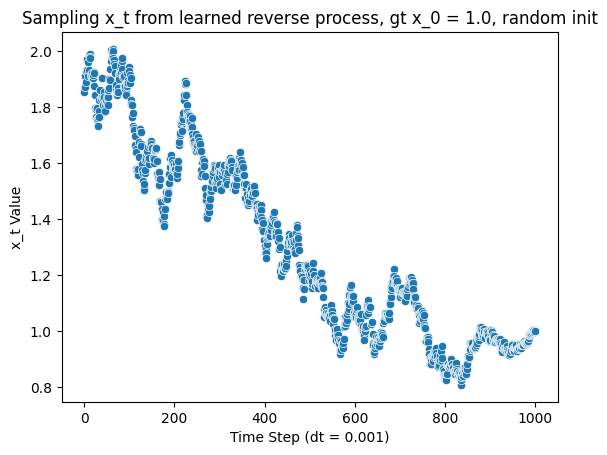

In [49]:
sns.scatterplot([x for x in range(len(x_t_list))], x_t_list)
plt.xlabel('Time Step (dt = 0.001)')
plt.ylabel('x_t Value')
plt.title('Sampling x_t from learned reverse process, gt x_0 = 1.0, random init')